In [57]:
import importlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np
from PIL import Image

import Helper_Build_UNet_Model
import Helper_Create_Postprocessing_Model
import Helper_Calc_Mean_Alias_Value_Of_One_Image 
import Helper_White_Amount_of_UNet_Out

importlib.reload(Helper_Build_UNet_Model)
importlib.reload(Helper_Create_Postprocessing_Model)
importlib.reload(Helper_Calc_Mean_Alias_Value_Of_One_Image)
importlib.reload(Helper_White_Amount_of_UNet_Out)

from Helper_Build_UNet_Model import build_unet_model
from Helper_Create_Postprocessing_Model import create_postprocessing_model, tf_inv_fourier_trans
from Helper_Calc_Mean_Alias_Value_Of_One_Image import calc_mean_alias_value_of_one_image

from tqdm import tqdm

import matplotlib.pyplot as plt

from UNet_Fourier_Facilities import Fourier_Images

import time


In [58]:
model_cnn = tf.keras.models.load_model("./cnn_models/single_rgb_image_regression_V02_epochs_100_1653595623")


In [59]:
np.random.seed = 42
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


## Load Images

In [60]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_100_pics\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_100_pics\\clean_aligned"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [61]:
train_filmed_imgs = []
train_clean_imgs = []

In [62]:
OFFSET = 200
abbruch_idx = 30


def my_train_filmed_gen():
    for i, addr_filmed in enumerate(os.listdir(TRAIN_FILMED_PATH)):
        img =  plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]

def my_train_clean_gen():
    for i, addr_clean in enumerate(os.listdir(TRAIN_CLEAN_PATH)):
        img =  plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]


train_filmed_img_gen_obj = my_train_filmed_gen()
train_clean_img_gen_obj = my_train_clean_gen()

## Build U-Net-Model

In [63]:
model_u_net = build_unet_model(IMG_WIDTH, IMG_HEIGHT)
# model_u_net.summary()


# Build Postprecessing Model

In [64]:
# postprocessing_model = create_postprocessing_model()
# postprocessing_model.summary()


## Custom Train loop


In [65]:
# Custom train loop

SAFE_RESULTS = True
WRITE_PATH = "D:\\Main\\MA_PROGR\\Data\\UNET_Output\\Session13"

show_intermediate_pics = False

RGB_WEIGHTS = [0.299, 0.587, 0.114]

WHITE_AMOUNT_LOSS_WHEIGHT = 0.5


overall_train_loss = []

execute_UNet_model = tf.function(model_u_net)
execute_cnn_model = tf.function(model_cnn)
# execute_postprocessing_model = tf.function(postprocessing_model)

NUM_EPOCHS = 10
batch_size_cnn = 1
batch_size_unet = 5


optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanAbsoluteError()
epoch_loss = tf.keras.metrics.MeanAbsoluteError()


train_writer = tf.summary.create_file_writer("u_net_logs/train/")
test_writer = tf.summary.create_file_writer("u_net_logs/test/")

y_true = tf.constant(0, dtype=tf.float16, name="y_true")

jump_to_new_epoch = False

for epoch in range(NUM_EPOCHS):

    print(f"Start of epoch {epoch}")
    jump_to_new_epoch = False

    # Mache neue Generater, sodass wieder durch alle Bilder durchgegange wird für die nächste Epoche:
    train_filmed_img_gen_obj = my_train_filmed_gen()
    train_clean_img_gen_obj = my_train_clean_gen()

    # ---------------------------------------------------------------------------- BATCHES SAMMELN Start ----------------------------------------------------------------------------------------
    train_step = 0

    for batch_idx in tqdm(range(batch_size_unet), desc="training...", ascii=False, ncols=75):
        print("next batch...")
        cnn_mean_prediction_values = []

        with tf.GradientTape() as tape:

            # Bilder für den nächsten Batch sammeln:
            for i in range(batch_size_unet):
                try:
                    x_filmed = train_filmed_img_gen_obj.__next__()
                    x_clean = train_clean_img_gen_obj.__next__()
                except StopIteration as e:
                    print(
                        "------------------------Am Ende angelangt, gehe in neue Epoche")

                    jump_to_new_epoch = True

                if jump_to_new_epoch == True:
                    # Alle Bilder sind aufgebraucht, gehe in neue Epoche
                    break

                y_pred, differenzbild_fourier_px, u_net_output, image_processed_rgb = calc_mean_alias_value_of_one_image(
                    x_filmed,
                    x_clean,
                    show_intermediate_pics,
                    IMG_WIDTH,
                    IMG_HEIGHT,
                    execute_cnn_model,
                    execute_UNet_model
                )
                cnn_mean_prediction_values.append(y_pred)

                # print("y_pred: ")
                # print(y_pred)

                # ---------------------------------------------------------------------------- BATCHES SAMMELN ENDE ----------------------------------------------------------------------------------------

            if SAFE_RESULTS:
                plt.imsave(
                    f"{WRITE_PATH}\\x_filmed_{epoch}_{batch_idx}.png", x_filmed)
                plt.imsave(
                    f"{WRITE_PATH}\\x_clean_{epoch}_{batch_idx}.png", x_clean)

                plt.imsave(f"{WRITE_PATH}\\differenzbild_{epoch}_{batch_idx}.png",
                           differenzbild_fourier_px.reshape((IMG_WIDTH, IMG_HEIGHT)), cmap="gray")

                u_net_output_for_img_save = np.array(
                    u_net_output).reshape(IMG_WIDTH, IMG_HEIGHT)
                # print("---------------> u_net_output_for_img_save")
                # print(u_net_output_for_img_save)
                plt.imsave(f"{WRITE_PATH}\\unet_output_{epoch}_{batch_idx}.png",
                           u_net_output_for_img_save, cmap="gray")

                # image_processed_rgb umformen in Numpy-Array
                image_processed_rgb_for_img_save = np.array(
                    image_processed_rgb).reshape((IMG_WIDTH, IMG_HEIGHT, 3))
                try:
                    plt.imsave(
                        f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.png", image_processed_rgb_for_img_save)
                except ValueError:
                    print(
                        "------------------------- Speichern hat nicht geklappt, speichere stattdessen numpy array zur Inspektion:")
                    np.save(f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.npy",
                            image_processed_rgb_for_img_save)

            if jump_to_new_epoch == True:
                # Alle Bilder sind aufgebraucht, gehe in neue epoche
                break

            # ----------- Calc loss for one batch -----------

            y_true = tf.zeros(batch_size_unet, 1)

            # print("cnn_mean_prediction_values.shape: ")
            # print(np.array(cnn_mean_prediction_values).shape)

            loss = loss_fn(y_true=y_true, y_pred=cnn_mean_prediction_values)

            # ------------- White Amount zu Loss-Function addieren ----------

            white_amount_of_UNet_out = Helper_White_Amount_of_UNet_Out.calc_white_amount_of_unet_out(
                u_net_output_for_img_save
            )

            print("------------------------->>>> white_amount_of_UNet_out:")
            print(white_amount_of_UNet_out)

            # print("loss for one batch: ")
            # print(loss)

            loss = loss + white_amount_of_UNet_out * WHITE_AMOUNT_LOSS_WHEIGHT

            gradients = tape.gradient(loss, model_u_net.trainable_weights)
            del cnn_mean_prediction_values[:]
            # print("gradients: ")
            # print(gradients)

            # Optimize the model:
            optimizer.apply_gradients(
                zip(gradients, model_u_net.trainable_variables))

            tmp = epoch_loss.update_state(y_true, y_pred)

            # print("tmp")
            # print(tmp)

            # print("------------------------------------")
            # print("y_true:")
            # print(y_true)

            # print("y_pred")
            # print(y_pred)
            # print("------------------------------------")

            # with train_writer.as_default():
            #     tf.summary.scalar("Loss", loss, step=train_step)
            #     tf.summary.scalar(
            #         "Accuracy", epoch_loss.result(), step=train_step,
            #     )
            # train_step += 1

        # End Epoch

        print(f"--------------- epoch_loss: {epoch_loss.result()}")
        overall_train_loss.append(epoch_loss.result())


# overall_train_loss = epoch_loss.result()
# print(f"overall_train_loss: {overall_train_loss}")
# epoch_loss.reset_states()


Start of epoch 0


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.5002342


training...:  20%|█████▍                     | 1/5 [00:05<00:22,  5.60s/it]

--------------- epoch_loss: 0.1263686567544937
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.50169337


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.07s/it]

--------------- epoch_loss: 0.11162019520998001
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.50382435


training...:  60%|████████████████▏          | 3/5 [00:15<00:09,  4.91s/it]

--------------- epoch_loss: 0.10858064144849777
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.50699216


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.86s/it]

--------------- epoch_loss: 0.11542493104934692
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.51120555


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.93s/it]


--------------- epoch_loss: 0.1084727868437767
Start of epoch 1


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.5187572


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.77s/it]

--------------- epoch_loss: 0.11486747860908508
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.5297103


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.84s/it]

--------------- epoch_loss: 0.11585234850645065
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.5593389


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.82s/it]

--------------- epoch_loss: 0.11636388301849365
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.67348975


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.89s/it]

--------------- epoch_loss: 0.11222328245639801
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.85874856


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.87s/it]


--------------- epoch_loss: 0.10357074439525604
Start of epoch 2


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.94585145


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.87s/it]

--------------- epoch_loss: 0.09569238871335983
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.95093185


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.93s/it]

--------------- epoch_loss: 0.08858846873044968
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.9343113


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.83s/it]

--------------- epoch_loss: 0.0830625668168068
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.9018209


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.87s/it]

--------------- epoch_loss: 0.07805328071117401
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.86511517


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.85s/it]


--------------- epoch_loss: 0.073706716299057
Start of epoch 3


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.8366443


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.80s/it]

--------------- epoch_loss: 0.06987256556749344
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.8046387


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.84s/it]

--------------- epoch_loss: 0.06625892221927643
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7630137


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.82s/it]

--------------- epoch_loss: 0.06317305564880371
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.73640066


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.79s/it]

--------------- epoch_loss: 0.06020648777484894
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.71514523


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.81s/it]


--------------- epoch_loss: 0.05758427456021309
Start of epoch 4


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.6985043


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.89s/it]

--------------- epoch_loss: 0.055382877588272095
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.68048644


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.88s/it]

--------------- epoch_loss: 0.05310709401965141
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.66173893


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.88s/it]

--------------- epoch_loss: 0.05128966271877289
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.681692


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.85s/it]

--------------- epoch_loss: 0.04946238920092583
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7053493


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.85s/it]


--------------- epoch_loss: 0.04771752655506134
Start of epoch 5


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7188562


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.79s/it]

--------------- epoch_loss: 0.046172134578228
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7227434


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.81s/it]

--------------- epoch_loss: 0.0450819693505764
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7231025


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.88s/it]

--------------- epoch_loss: 0.044097159057855606
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7240778


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.88s/it]

--------------- epoch_loss: 0.04321948066353798
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7226566


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.91s/it]


--------------- epoch_loss: 0.04203013703227043
Start of epoch 6


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.72306305


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.81s/it]

--------------- epoch_loss: 0.041129425168037415
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7312472


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.91s/it]

--------------- epoch_loss: 0.039977263659238815
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7375643


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.88s/it]

--------------- epoch_loss: 0.03897728770971298
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7396306


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.91s/it]

--------------- epoch_loss: 0.038057465106248856
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7421365


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.88s/it]


--------------- epoch_loss: 0.0371917262673378
Start of epoch 7


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.74413896


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  5.00s/it]

--------------- epoch_loss: 0.03647291660308838
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.74365234


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.88s/it]

--------------- epoch_loss: 0.03563300520181656
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7454834


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.87s/it]

--------------- epoch_loss: 0.03499540686607361
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7465369


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:05,  5.01s/it]

--------------- epoch_loss: 0.03434664011001587
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.74795735


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.95s/it]


--------------- epoch_loss: 0.033662743866443634
Start of epoch 8


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7486572


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.99s/it]

--------------- epoch_loss: 0.03312453255057335
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.749775


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.00s/it]

--------------- epoch_loss: 0.03248068690299988
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7515259


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.93s/it]

--------------- epoch_loss: 0.03197032958269119
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7526777


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.95s/it]

--------------- epoch_loss: 0.03142903372645378
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.75323486


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.97s/it]


--------------- epoch_loss: 0.0308879092335701
Start of epoch 9


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7540881


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.96s/it]

--------------- epoch_loss: 0.03045039251446724
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7540289


training...:  40%|██████████▊                | 2/5 [00:10<00:15,  5.04s/it]

--------------- epoch_loss: 0.029962509870529175
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7557373


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.95s/it]

--------------- epoch_loss: 0.029513007029891014
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.7575658


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.96s/it]

--------------- epoch_loss: 0.02906600572168827
next batch...
############## betrete calc_white_amount_of_unet_out
------------------------->>>> white_amount_of_UNet_out:
0.75933784


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.98s/it]

--------------- epoch_loss: 0.02865011617541313


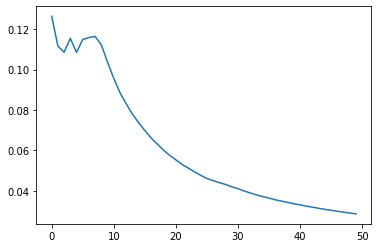

In [66]:

plt.plot(overall_train_loss)

In [67]:
len(np.array(overall_train_loss))


50

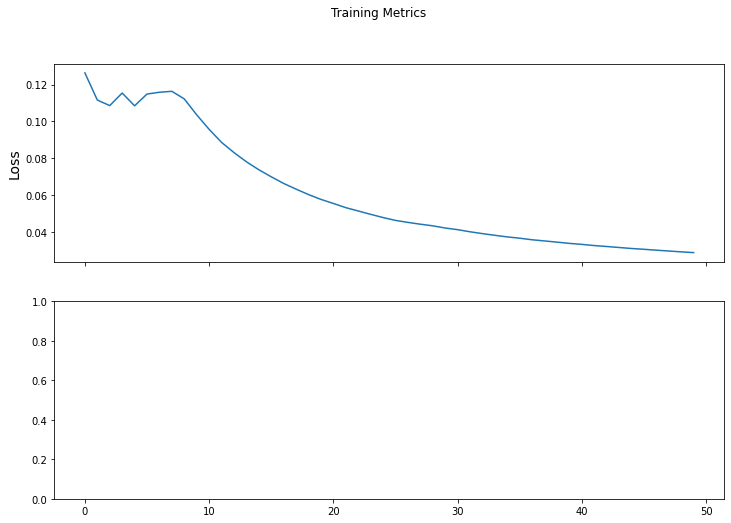

In [68]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(overall_train_loss)

plt.show()


In [69]:
# test_img = img[400:528, 400:528,:]
# test_img = np.array(test_img).reshape(1, 128 , 128 , 3)

# # plt.imshow(test_img)

# test_img= tf.convert_to_tensor(test_img, dtype=tf.float32)

# test_img


In [70]:
# import tensorflow as tf
# BATCH_SIZE = 1
# NUM_BOXES = 3
# IMAGE_HEIGHT = 128
# IMAGE_WIDTH = 128
# CHANNELS = 3
# CROP_SIZE = (24, 24)

# test_img = img[400:528, 400:528, :]
# test_img = np.array(test_img).reshape(1, 128, 128, 3)

# # plt.imshow(test_img)

# test_img = tf.convert_to_tensor(test_img, dtype=tf.float32)
# image = test_img
# boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# # plt.imshow(np.array(image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
# # plt.show()
# box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
#                                 maxval=BATCH_SIZE, dtype=tf.int32)
# output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
# output.shape  # => (5, 24, 24, 3)

# plt.imshow(output[2])
